In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from utils.model_inference_plots import *

In [2]:
df = pd.read_parquet('data/v80/final_model_data_the_scaled.parquet')
df[['Event_class', '|V_perp|']] = pd.read_parquet('data/v80/final_matrix_the_perp_labeled_v80.parquet')[['Event_class', '|V_perp|']][2:].reset_index(drop=True)
event_df = pd.read_csv('data/event_data_all_perp_80_avg.csv').query("satellite_name == 'THEMIS E'").reset_index(drop=True)

In [3]:
X_test = df[['Bx', 'By', 'Bz', 'Bx_lag_1', 'Bx_lag_2', 'By_lag_1',
             'By_lag_2', 'Bz_lag_1', 'Bz_lag_2', 'Bx_conditional_vol',
             'By_conditional_vol', 'Bz_conditional_vol', 'Bx_rolling_stdev',
             'By_rolling_stdev', 'Bz_rolling_stdev']].values

y_test = df['Event_label_80'].values

In [4]:
df['Time'] = pd.to_datetime(df['Epoch_time'], unit='s', utc=True)

In [5]:
test_size = len(X_test)
n_features = X_test.shape[1]

In [6]:
y_pred_probas = np.load("models/mosrl_80_the_pred_probas.npy")

In [7]:
threshold = 0.5
y_pred = (y_pred_probas >= threshold).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85  11131422
           1       0.67      0.90      0.77   5589714

    accuracy                           0.82  16721136
   macro avg       0.80      0.84      0.81  16721136
weighted avg       0.85      0.82      0.82  16721136



In [8]:
df['Event_pred_probas'] = y_pred_probas
df['Event_pred'] = y_pred

In [9]:
df['Time_diff'] = df['Time'].diff().dt.total_seconds().fillna(0)

In [10]:
tha_start_time = (pd.to_datetime(event_df['start_time']).astype('int64') / 10**9).values
tha_end_time = (pd.to_datetime(event_df['end_time']).astype('int64') / 10**9).values

event_indices = []

for idx, row in event_df.iterrows():
    start_idx = np.searchsorted(df['Epoch_time'], tha_start_time[idx], side='left')
    end_idx = np.searchsorted(df['Epoch_time'], tha_end_time[idx], side='right')

    event_indices.append(df.iloc[start_idx:end_idx].index.values)

In [11]:
ratios_by_class = defaultdict(list)

for i, indices in enumerate(event_indices):
    group = df.loc[indices]
    
    true_label = group['Event_label_80'].values
    pred_label = group['Event_pred'].values
    cls = group['Event_class'].iloc[0]

    N_j = np.sum(true_label)
    Nt_j = np.sum(pred_label == 1)

    ratio = Nt_j / N_j
    ratios_by_class[cls].append(ratio)

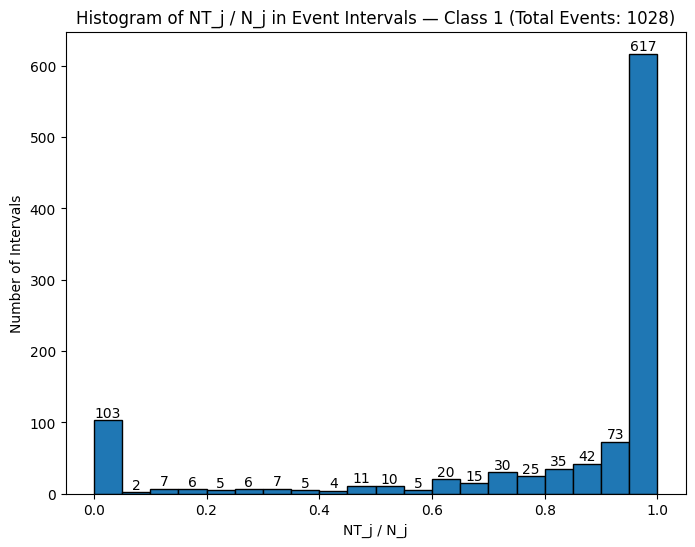

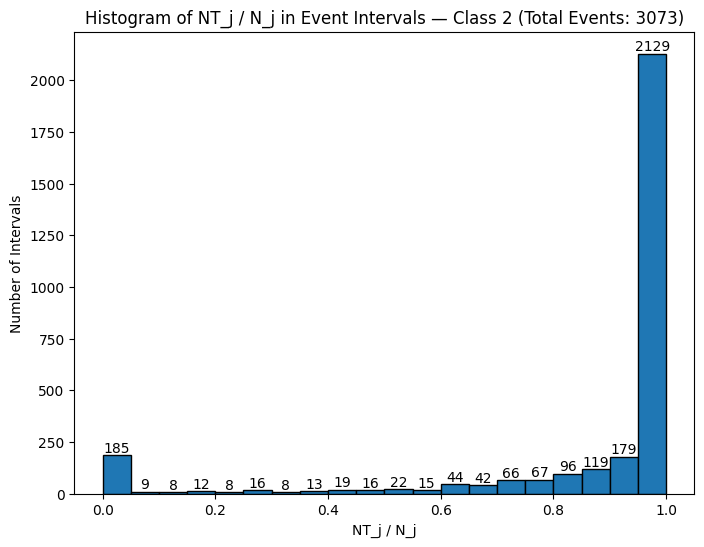

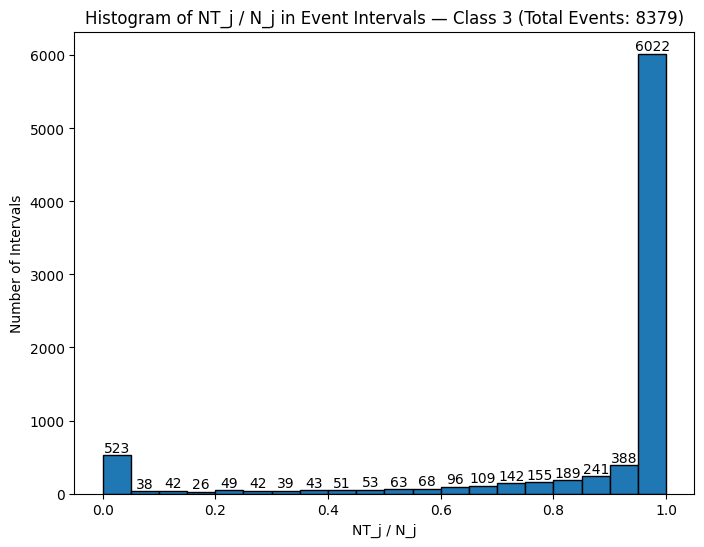

In [12]:
for cls, ratios in sorted(ratios_by_class.items()):
    plt.figure(figsize=(8, 6))
    counts, bins, patches = plt.hist(ratios, edgecolor='black', bins=20)
    for count, bin_edge in zip(counts, bins[:-1]):
        if count > 0:
            plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('NT_j / N_j')
    plt.ylabel('Number of Intervals')
    plt.title(f'Histogram of NT_j / N_j in Event Intervals — Class {cls} (Total Events: {len(ratios)})')
    plt.show()

In [15]:
ratios_by_year_class = defaultdict(list)

event_years = pd.to_datetime(event_df['start_time']).dt.year.values
event_classes = event_df['event_class'].values

for i, indices in enumerate(event_indices):
    group = df.loc[indices]

    true_label = group['Event_label_80'].values
    pred_label = group['Event_pred'].values
    year = event_years[i]
    cls = event_classes[i]

    N_j = np.sum(true_label)
    Nt_j = np.sum(pred_label == 1)

    if N_j > 0:
        ratio = Nt_j / N_j
        ratios_by_year_class[(year, cls)].append(ratio)

low_high_ratios = defaultdict(dict)

for (year, cls), ratios in ratios_by_year_class.items():
    low_count = sum(r < 0.05 for r in ratios)
    high_count = sum(r > 0.95 for r in ratios)
    if high_count > 0:
        low_high_ratios[cls][year] = low_count / high_count

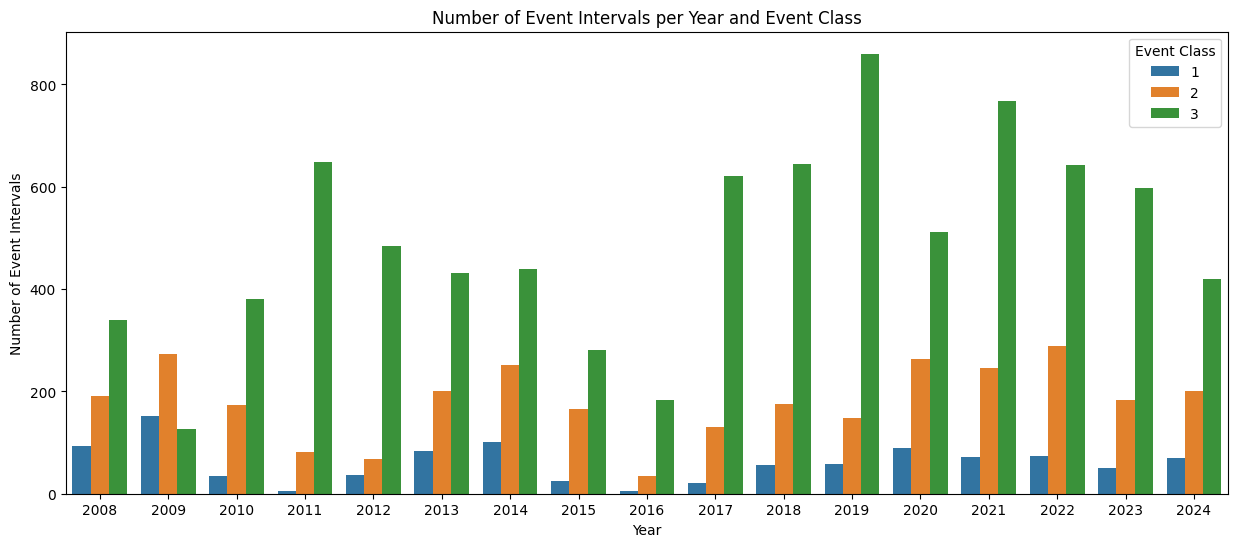

In [14]:
event_years = pd.to_datetime(event_df['start_time']).dt.year.values
event_classes = event_df['event_class'].values
event_interval_counts = defaultdict(int)

for year, cls in zip(event_years, event_classes):
    if year != 2025:
        event_interval_counts[(year, cls)] += 1

counts_df = pd.DataFrame([
    {'Year': year, 'Event_class': cls, 'Event_count': count}
    for (year, cls), count in event_interval_counts.items()
])

plt.figure(figsize=(15, 6))
sns.barplot(x='Year', y='Event_count', hue='Event_class', data=counts_df, palette='tab10')
plt.title('Number of Event Intervals per Year and Event Class')
plt.xlabel('Year')
plt.ylabel('Number of Event Intervals')
plt.legend(title='Event Class')
plt.show()

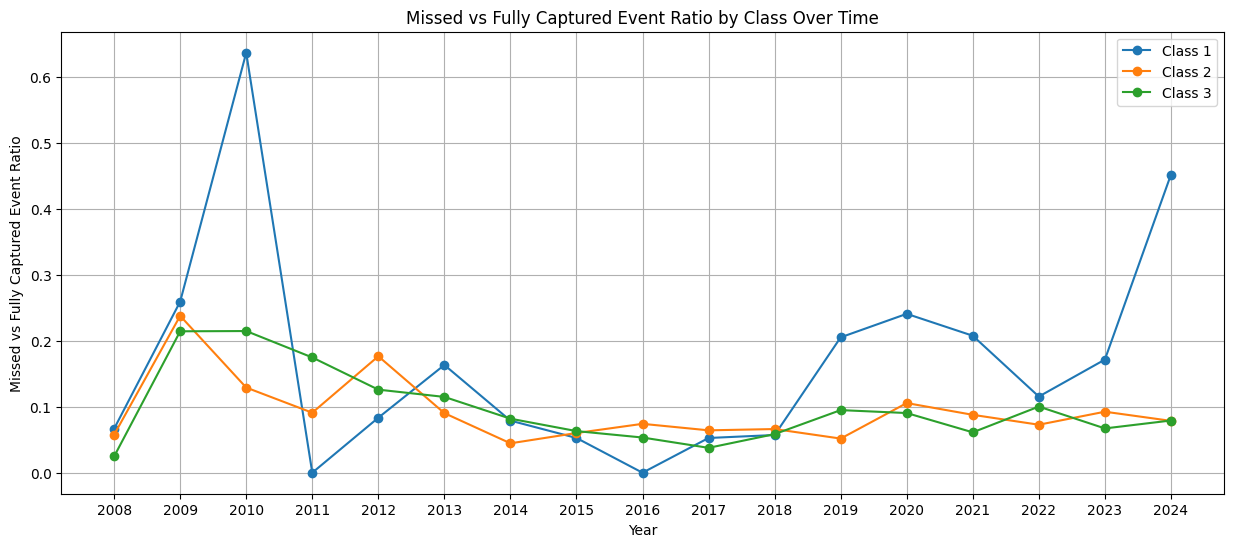

In [21]:
plt.figure(figsize=(15, 6))
colors = ['C0', 'C1', 'C2']
for idx, (cls, year_ratio_dict) in enumerate(sorted(low_high_ratios.items())):
        years = sorted(year_ratio_dict.keys())
        values = [year_ratio_dict[y] for y in years]
        plt.plot(years, values, label=f'Class {cls}', marker='o', color=colors[idx])

plt.xlabel('Year')
plt.ylabel('Missed vs Fully Captured Event Ratio')
plt.title('Missed vs Fully Captured Event Ratio by Class Over Time')
plt.xticks(list(range(2008, 2025)))
plt.legend()
plt.grid(True)
plt.show()

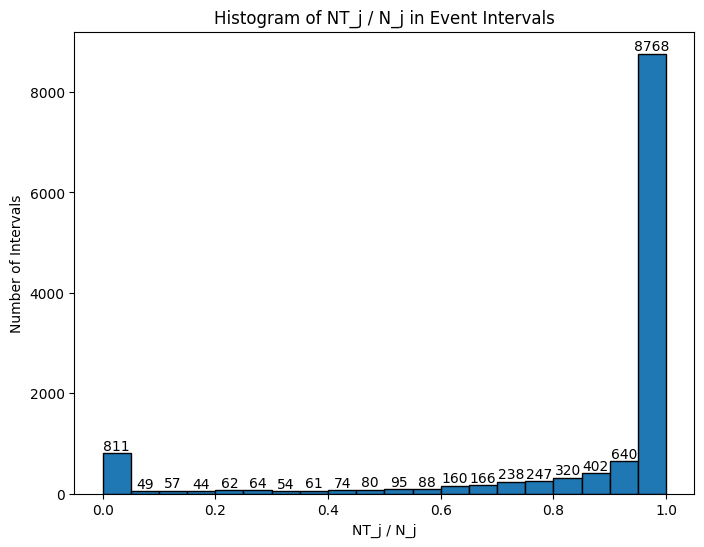

In [16]:
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(sum(ratios_by_class.values(), []), bins=20, edgecolor='k')
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
             ha='center', va='bottom', fontsize=10)

plt.xlabel("NT_j / N_j")
plt.ylabel("Number of Intervals")
plt.title("Histogram of NT_j / N_j in Event Intervals")
plt.show()

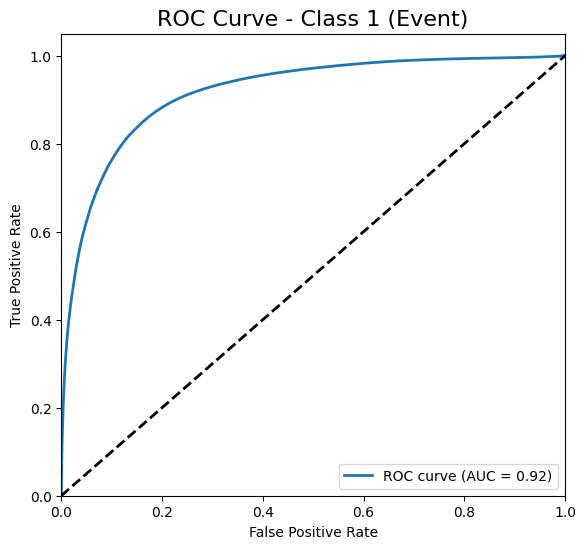

In [17]:
plot_positive_class_roc(y_test, y_pred_probas, dpi=100)

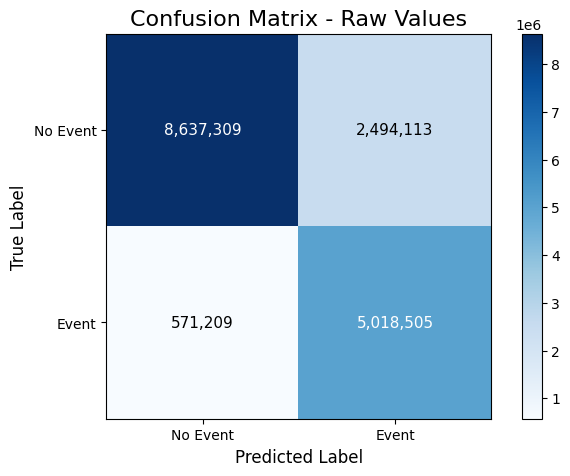

In [18]:
plot_raw_confusion_matrix(y_test, y_pred, dpi=100)

In [27]:
df['Satellite'] = len(df) * ['THEMIS E']

In [29]:
df['Class_change'] = (
    (df['Event_class'] != df['Event_class'].shift()) |
    (df['Time_diff'] > 300)
).cumsum()

valid_events = df[df['Event_label_80'] == 1]
event_groups = valid_events.groupby(['Class_change', 'Satellite', 'Event_class'])

In [30]:
low_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.05, side="lower")
high_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.9, side="upper")

In [31]:
false_events = df.query("Event_label_80 == 0 and Event_pred == 1")
false_sequences = false_events.groupby((false_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

non_events = df.query("Event_label_80 == 0 and Event_pred == 0")
non_event_sequences = non_events.groupby((non_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

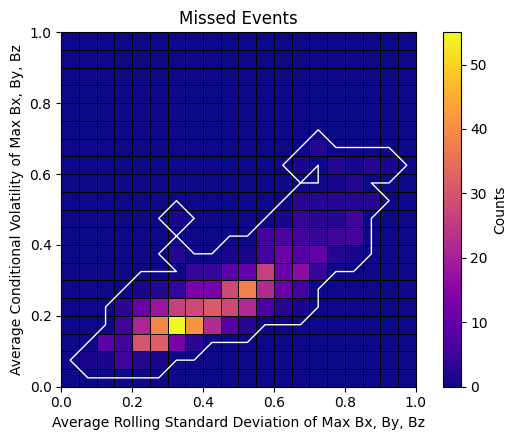

In [32]:
# plot_vol_stdev_histogram(extract_max_features(low_ratio_sequences, df, True), event_type='Missed')
# plot_vol_stdev_2d_histogram(extract_max_features(low_ratio_sequences, df, True), event_type='Missed')
plot_vol_stdev_2d_avg_histogram(extract_max_features(low_ratio_sequences, df, True), event_type='Missed')

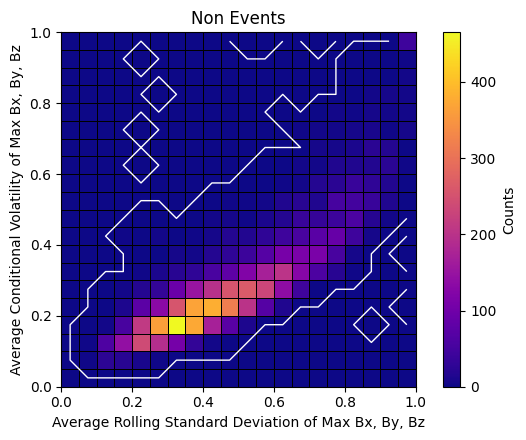

In [33]:
# plot_vol_stdev_histogram(extract_max_features(non_event_sequences, df, False), event_type='Non')
# plot_vol_stdev_2d_histogram(extract_max_features(non_event_sequences, df, False), event_type='Non')
plot_vol_stdev_2d_avg_histogram(extract_max_features(non_event_sequences, df, False), event_type='Non')

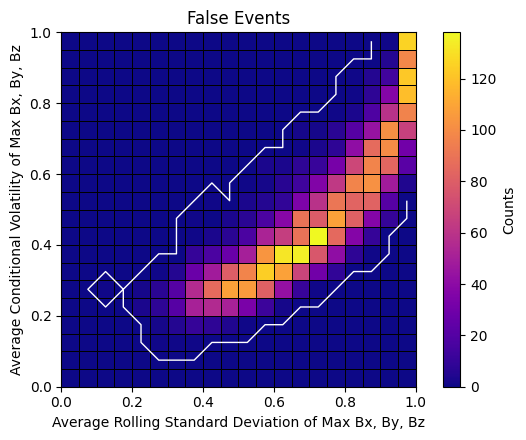

In [34]:
# plot_vol_stdev_histogram(extract_max_features(false_sequences, df, False), event_type='False')
# plot_vol_stdev_2d_histogram(extract_max_features(false_sequences, df, False), event_type='False')
plot_vol_stdev_2d_avg_histogram(extract_max_features(false_sequences, df, False), event_type='False')

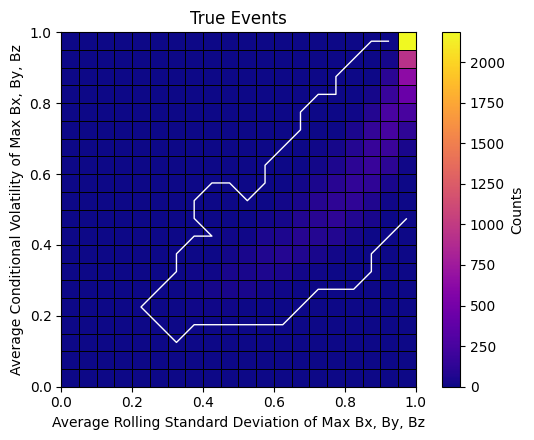

In [35]:
# plot_vol_stdev_histogram(extract_max_features(high_ratio_sequences, df, True), event_type='Captured')
# plot_vol_stdev_2d_histogram(extract_max_features(high_ratio_sequences, df, True), event_type='True')
plot_vol_stdev_2d_avg_histogram(extract_max_features(high_ratio_sequences, df, True), event_type='True')

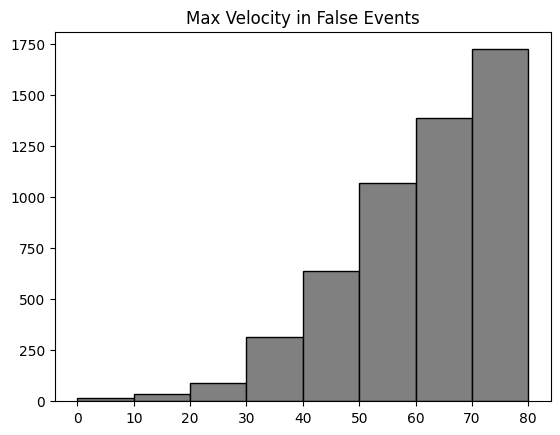

In [36]:
bins = np.arange(0, 90, step=10)
plt.hist(extract_max_features(false_sequences, df, False)['velocity'], bins=bins, color='gray', edgecolor='black')
plt.title("Max Velocity in False Events")
plt.xticks(bins)
plt.show()